<a href="https://colab.research.google.com/github/akfangus/DeepProject/blob/main/CNN_Satellite_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  # !sudo apt-get install -y fonts-nanum
  # !sudo fc-cache -fv
  # !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (44.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [27]:
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

In [2]:
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path=[]

for i in os.listdir('/content/drive/MyDrive/Colab Notebooks/Satellite Image/data'):
  print(i)
  for item in glob(f'/content/drive/MyDrive/Colab Notebooks/Satellite Image/data/{i}/*'):
    path.append(item)

len(path)


desert
green_area
water
cloudy


5632

In [5]:
#{} 딕셔너리, 형태로 해당 경로에 있는 디렉토리를 sorting한다음에 인덱스순서대로 딕셔너리화
cmap = {v:i for i,v in enumerate(sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/Satellite Image/data')))}

In [6]:
cmap

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51704 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51704 missing from current font.
  font.set_text(s, 0, flags=flags)


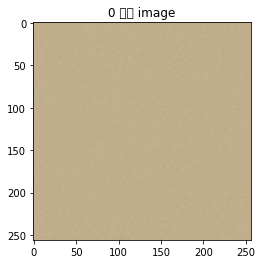

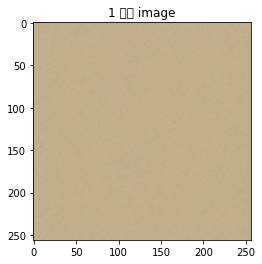

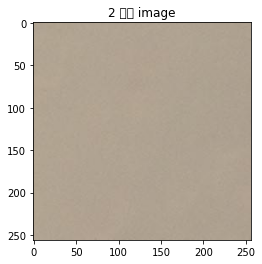

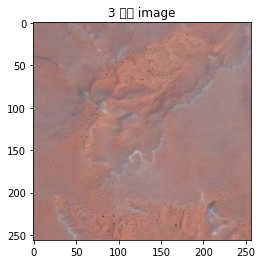

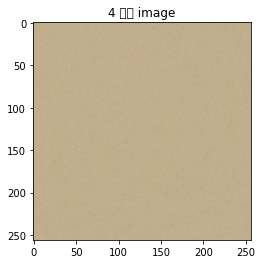

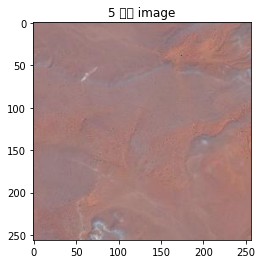

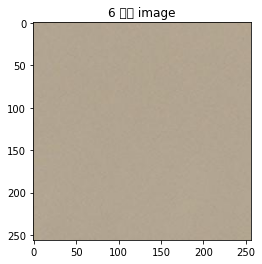

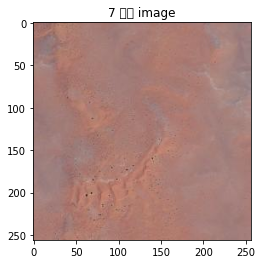

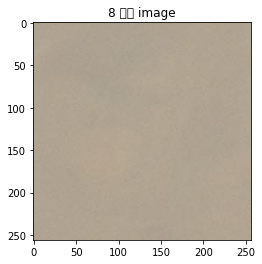

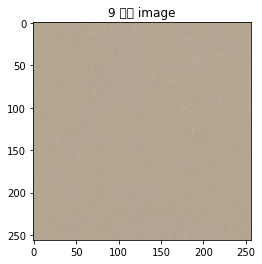

In [7]:
for i in range(10):
  plt.figure()
  imim = cv2.imread(path[i])[:,:,::-1]
  plt.imshow(imim)
  plt.title(f"{i} 번째 image")

plt.show()

In [ ]:
# trans = transforms.Compose([
#     transforms.ToTensor()])

# input = cv2.imread(path[0])
# print(input.shape)
# input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
# print(input.shape)
# input = trans(input)
# print(input.shape)

In [8]:
# VGG16 안쓴 일반 모델로 해보겟음   => VGG16과 비교? => normalize도 안하고 생이미지 그대로
class Satellite_Normal(Dataset):
  def __init__(self, path, cmap):
    # 클래스 초기화 함수
    self.path = path
    self.normalize = transforms.Compose([
                                         
              # transforms.Resize(256),              
              transforms.ToTensor(),
              # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])                    
    ])
    self.cmap = cmap

  def __len__(self):
    return len(self.path)

  def __getitem__(self, ix):
    # size는 256*256
    im = cv2.imread(self.path[ix])    
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im,(256,256))
    # im = cv2.resize(im, ())
    # im  = torch.tensor(im/255)
    im = self.normalize(im)
    # im = im.permute(2,0,1)
    

  # 타겟 매핑
    target = self.path[ix].split('/')[-2]
    label = cmap[target]

    return im.float().to(device),torch.tensor(int(label)).long().to(device)




In [ ]:
data = Satellite_Normal(path, cmap)

In [ ]:
data[0][0].shape

torch.Size([3, 256, 256])

In [9]:
from random import shuffle
from random import seed

In [ ]:
len(path)

5632

In [10]:
seed(42)
shuffle(path)

In [11]:
num = int(len(path) * 0.8)

In [12]:
train = path[:num]
val = path[num:]

train_data = Satellite_Normal(train, cmap)
val_data = Satellite_Normal(val, cmap)

train_dl = DataLoader(train_data, batch_size=32, shuffle = True, drop_last=True)
val_dl = DataLoader(val_data, batch_size=32, shuffle = False, drop_last=True)

In [13]:
device

'cuda'

In [14]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # self.keep_prob = 0.5
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc1 = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(16*16*128,64),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(64,4),
        nn.Softmax()
    )
        # L5 Final FC 625 inputs -> 10 outputs
    # self.fc2 = torch.nn.Linear(625, 10, bias=True)
    # torch.nn.init.xavier_uniform_(self.fc2.weight)



  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)

    return out

In [15]:
model = CNN().to(device)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=32768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(i

In [18]:
from torchsummary import summary
# 만들어진 모델 어떻게 돌아가는지 테스트 및 성능 해보는거같음.
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         147,584
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                   [-1, 64]       2,097,216
             ReLU-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
len(train_dl)

140

In [19]:
# 잘 되는지 안되는지 샘플 몇개만 뽑아서 해보자
train_sample = path[:100]

train_data_sample = Satellite_Normal(train_sample, cmap)


train_dl_sample = DataLoader(train_data_sample, batch_size=32, shuffle = True, drop_last=True)

In [23]:
# 이제 학습 시켜보자 (샘플)
train_losses, valid_losses = [],[]
# 15epoch 수행 예정
n_epochs=15

for epochs in tqdm(range(n_epochs)):
  # train, val loss값 초기화
  train_loss=0.0
  val_loss=0.0
  # 모델을 학습 모드로 변환 / 평가 모드는 model.eval() 로 할 수 있다.
  model.train()
  for data, target in tqdm(train_dl_sample):
    # 파이토치는 미분을 통해 얻은 기울기를 이전에 계산된 기울기 값에 누적시키는 특징이 있습니다
    # 그렇기 때문에 optimizer.zero_grad()를 통해 미분값을 계속 0으로 초기화
    optimizer.zero_grad()
    # data에 대한 예측값 생성
    prediction = model(data)
    # 예측과 target에 대한 loss function수행
    loss = loss_fn(prediction, target)
    # loss에 backwoar()를 계산하면 모델을 구성하는 파라미터에 대한 gradient를 계산한다.
    # backward()는 암묵적으로 loss값이 스칼라라고 가정하기때문에 scalar값으로 만들어주어야함.
    # backpropagation으로 하는듯.
    loss.backward()
    # optimizer가 step()메소드를 통해 parameter를 업데이터한다.
    optimizer.step()
    train_loss += loss.item() * data.size(0)

  # batch normalization 이나 dropout이 들어있는 모델은 batchsize에 따라 결과가 달라진다던가 실행 시킬때마다 결과가 달라져 학습에 영향을 미침 (드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력)
  # 훈련후 결과 계산만을 위해 model.eval()을 실행 시켜줘야한다고함.
  # model.eval()

  # for data, target in val_dl:
  #   prediction = model(data)
  #   loss = loss_fn(prediction, target)
  #   val_loss += loss.item() * data.size(0)
  
  # for문에서 train_loss에 모든 loss의 합을 더햇으므로 최종 loss는 갯수만큼 나눠야겟죠?
  train_loss = train_loss / len(train_data_sample)
  # val_loss = val_loss / len(val_dl.sampler)

  # loss 리스트에 append
  train_losses.append(train_loss)
  # valid_losses.append(val_loss)

  print("Epoch : {} \tTraining Loss: {:.6f} \t".format(epochs,train_loss))


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

  7%|▋         | 1/15 [00:02<00:29,  2.13s/it]

Epoch : 0 	Training Loss: 1.233139 	



 13%|█▎        | 2/15 [00:03<00:20,  1.57s/it]

Epoch : 1 	Training Loss: 1.170805 	



 20%|██        | 3/15 [00:04<00:16,  1.38s/it]

Epoch : 2 	Training Loss: 1.145246 	



 27%|██▋       | 4/15 [00:05<00:14,  1.29s/it]

Epoch : 3 	Training Loss: 1.130026 	



 33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]

Epoch : 4 	Training Loss: 1.127187 	



 40%|████      | 6/15 [00:07<00:10,  1.19s/it]

Epoch : 5 	Training Loss: 1.131140 	



 47%|████▋     | 7/15 [00:08<00:09,  1.18s/it]

Epoch : 6 	Training Loss: 1.140807 	



 53%|█████▎    | 8/15 [00:10<00:08,  1.17s/it]

Epoch : 7 	Training Loss: 1.146130 	



 60%|██████    | 9/15 [00:11<00:06,  1.16s/it]

Epoch : 8 	Training Loss: 1.107488 	



 67%|██████▋   | 10/15 [00:12<00:05,  1.16s/it]

Epoch : 9 	Training Loss: 1.110866 	



 73%|███████▎  | 11/15 [00:13<00:04,  1.16s/it]

Epoch : 10 	Training Loss: 1.164506 	



 80%|████████  | 12/15 [00:14<00:03,  1.15s/it]

Epoch : 11 	Training Loss: 1.141812 	



 87%|████████▋ | 13/15 [00:15<00:02,  1.15s/it]

Epoch : 12 	Training Loss: 1.123219 	



 93%|█████████▎| 14/15 [00:17<00:01,  1.14s/it]

Epoch : 13 	Training Loss: 1.116980 	



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]

Epoch : 14 	Training Loss: 1.140867 	


In [25]:
# 이제 학습 시켜보자 (실제 데이터)
train_losses, valid_losses = [],[]
# 15epoch 수행 예정
n_epochs=5

for epochs in tqdm(range(n_epochs)):
  # train, val loss값 초기화
  train_loss=0.0
  val_loss=0.0
  # 모델을 학습 모드로 변환 / 평가 모드는 model.eval() 로 할 수 있다.
  model.train()
  for data, target in tqdm(train_dl):
    # 파이토치는 미분을 통해 얻은 기울기를 이전에 계산된 기울기 값에 누적시키는 특징이 있습니다
    # 그렇기 때문에 optimizer.zero_grad()를 통해 미분값을 계속 0으로 초기화
    optimizer.zero_grad()
    # data에 대한 예측값 생성
    prediction = model(data)
    # 예측과 target에 대한 loss function수행
    loss = loss_fn(prediction, target)
    # loss에 backwoar()를 계산하면 모델을 구성하는 파라미터에 대한 gradient를 계산한다.
    # backward()는 암묵적으로 loss값이 스칼라라고 가정하기때문에 scalar값으로 만들어주어야함.
    # backpropagation으로 하는듯.
    loss.backward()
    # optimizer가 step()메소드를 통해 parameter를 업데이터한다.
    optimizer.step()
    train_loss += loss.item() * data.size(0)

  # batch normalization 이나 dropout이 들어있는 모델은 batchsize에 따라 결과가 달라진다던가 실행 시킬때마다 결과가 달라져 학습에 영향을 미침 (드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력)
  # 훈련후 결과 계산만을 위해 model.eval()을 실행 시켜줘야한다고함.
  model.eval()

  for data, target in val_dl:
    prediction = model(data)
    loss = loss_fn(prediction, target)
    val_loss += loss.item() * data.size(0)
  
  # for문에서 train_loss에 모든 loss의 합을 더햇으므로 최종 loss는 갯수만큼 나눠야겟죠?
  train_loss = train_loss / len(train_dl)
  val_loss = val_loss / len(val_dl)

  # loss 리스트에 append
  train_losses.append(train_loss)
  valid_losses.append(val_loss)

  print("Epoch : {} \tTraining Loss: {:.6f} \tValidation Loss {:.6f}".format(epochs,train_loss,val_loss))


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 20%|██        | 1/5 [16:02<1:04:11, 962.92s/it]

Epoch : 0 	Training Loss: 37.063797 	Validation Loss 38.396101



 40%|████      | 2/5 [17:07<21:42, 434.27s/it]  

Epoch : 1 	Training Loss: 38.564535 	Validation Loss 39.375344



 60%|██████    | 3/5 [18:08<08:47, 263.79s/it]

Epoch : 2 	Training Loss: 35.436878 	Validation Loss 37.985534



 80%|████████  | 4/5 [19:08<03:03, 183.60s/it]

Epoch : 3 	Training Loss: 35.046438 	Validation Loss 34.692597



100%|██████████| 5/5 [20:09<00:00, 241.88s/it]

Epoch : 4 	Training Loss: 33.549168 	Validation Loss 32.881413


# result
학습할수록 loss값이 점점 줄어드는것 확인 그러나 더 학습시키기에 시간 및 colab의 gpu할당량에 문제가 있는거 같아서 천천히 계속 수정 해나갈 예정.
---
vgg16을 썼을땐 어떨까?

In [26]:
# 모델을 만들어보자
# vgg16 선언.
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [28]:
class ASL(Dataset):
    def __init__(self,path,cmap):
      # 클래스 초기화 함수 ASK(path, cmap)값을 넣어서 초기설정
        self.path = path
        self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
        self.cmap = cmap
    def __len__(self):
      # 길이를 return 하게해주는함수 len()을 쓸수있게됨
        return len(self.path)
    
    def __getitem__(self,ix):
      # 인덱스로 값을 출력할수 있게 해주는 함수
        # opencv로 이미지를 읽어옴 opencv는 RGB가 아니라 BGR형식이기때문에 이미지에서 [:,:,::-1]로 채널을 거꾸로 읽어준다고한다.
        im = cv2.imread(self.path[ix])[:,:,::-1]
        # VGG16은 224,224를 인풋으로 받아온다고함.
        im = cv2.resize(im,(224,224))
        # 입력으로 하기위한 텐서변환.
        im = torch.tensor(im/255)
        # 인풋의 shape가 (width, height, channel)로 되어있는데 이걸 (channel, width, height) 형태로 변경해야하기 때문에 permute()함수를 씀.
        im = im.permute(2,0,1)
        # Nomalize init에서 선언한거 실행
        im = self.normalize(im)
        # 이미지 타겟 mapping하기위해 디렉토리에서 값을 뽑아옴
        target = self.path[ix].split("/")[-2]
        # 매핑된값 label로 저장,
        label = cmap[target]
        
        return im.float().to(device),torch.tensor(int(label)).long().to(device)    

In [29]:
# 모델의 일부를 고정하고 나머지를 훈련하려는 경우 고정하려는 매개변수의 requires_grad를 False로 설정.
# 이경우는 전체 고정시키고 avgpool classifier를 재선언한 모델로 결국 Convolution 만 고정하려는 목적인거같다.
for param in model.parameters():
  param.requires_grad  = False

# 원래는 (7,7)인데 (1,1)로 원본 그대로를? 하는건가?
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

model.classifier = nn.Sequential(
    # 일자 벡터화
    nn.Flatten(),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128,4),
    nn.Softmax()
)

In [30]:
# loss function = CrossEntropy => 다중 클래스 분류에 자주 사용되는 Loss function => log_softmax와 nll_loss가 하나의 함수로 합쳐진 형태라고함.

# optimizer = Adam ==> Adam method는 Adagrad + RMSProp
# Adam은 stepsize가 gradient의 rescaling에 영향 받지않아 gradient가 커져도 stepsize는 bound 되어있어 어떠한 objectfunction을 사용한다 하더라도 안정적으로 최적화를 위한 하강이 가능하다고 한다.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
from torchsummary import summary
# 만들어진 모델 어떻게 돌아가는지 테스트 및 성능 해보는거같음.
summary(model,  input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [33]:
# 이제 학습 시켜보자 (실제 데이터)
train_losses_vgg, valid_losses_vgg = [],[]
# 15epoch 수행 예정
n_epochs=5

for epochs in tqdm(range(n_epochs)):
  # train, val loss값 초기화
  train_loss=0.0
  val_loss=0.0
  # 모델을 학습 모드로 변환 / 평가 모드는 model.eval() 로 할 수 있다.
  model.train()
  for data, target in tqdm(train_dl):
    # 파이토치는 미분을 통해 얻은 기울기를 이전에 계산된 기울기 값에 누적시키는 특징이 있습니다
    # 그렇기 때문에 optimizer.zero_grad()를 통해 미분값을 계속 0으로 초기화
    optimizer.zero_grad()
    # data에 대한 예측값 생성
    prediction = model(data)
    # 예측과 target에 대한 loss function수행
    loss = loss_fn(prediction, target)
    # loss에 backwoar()를 계산하면 모델을 구성하는 파라미터에 대한 gradient를 계산한다.
    # backward()는 암묵적으로 loss값이 스칼라라고 가정하기때문에 scalar값으로 만들어주어야함.
    # backpropagation으로 하는듯.
    loss.backward()
    # optimizer가 step()메소드를 통해 parameter를 업데이터한다.
    optimizer.step()
    train_loss += loss.item() * data.size(0)

  # batch normalization 이나 dropout이 들어있는 모델은 batchsize에 따라 결과가 달라진다던가 실행 시킬때마다 결과가 달라져 학습에 영향을 미침 (드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력)
  # 훈련후 결과 계산만을 위해 model.eval()을 실행 시켜줘야한다고함.
  model.eval()

  for data, target in val_dl:
    prediction = model(data)
    loss = loss_fn(prediction, target)
    val_loss += loss.item() * data.size(0)
  
  # for문에서 train_loss에 모든 loss의 합을 더햇으므로 최종 loss는 갯수만큼 나눠야겟죠?
  train_loss = train_loss / len(train_dl)
  val_loss = val_loss / len(val_dl)

  # loss 리스트에 append
  train_losses_vgg.append(train_loss)
  valid_losses_vgg.append(val_loss)

  print("Epoch : {} \tTraining Loss: {:.6f} \tValidation Loss {:.6f}".format(epochs,train_loss,val_loss))


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 20%|██        | 1/5 [02:13<08:54, 133.72s/it]

Epoch : 0 	Training Loss: 38.598718 	Validation Loss 32.267852



 40%|████      | 2/5 [04:26<06:39, 133.08s/it]

Epoch : 1 	Training Loss: 29.943269 	Validation Loss 27.894802



 60%|██████    | 3/5 [06:39<04:26, 133.06s/it]

Epoch : 2 	Training Loss: 27.154134 	Validation Loss 26.453198



 80%|████████  | 4/5 [08:52<02:13, 133.02s/it]

Epoch : 3 	Training Loss: 26.092997 	Validation Loss 25.880967



100%|██████████| 5/5 [11:06<00:00, 133.22s/it]

Epoch : 4 	Training Loss: 25.558442 	Validation Loss 25.448865


In [34]:
train_losses, train_losses_vgg

([37.06379743303572,
  38.56453493663243,
  35.436877850123814,
  35.046438162667414,
  33.549167960030694],
 [38.598717771257675,
  29.94326902117048,
  27.154133565085274,
  26.092997482844762,
  25.55844192504883])

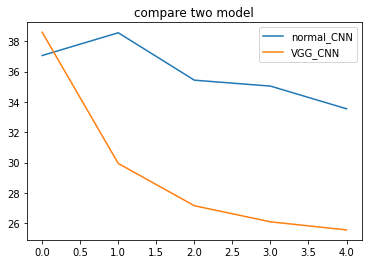

In [38]:
plt.figure()
plt.plot(train_losses)
plt.plot(train_losses_vgg)
plt.legend(['normal_CNN','VGG_CNN'])
plt.title('compare two model')
plt.show()

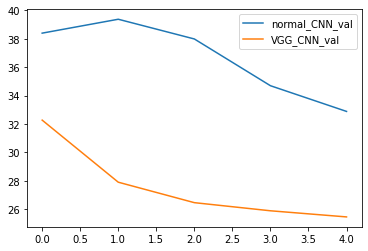

In [39]:
plt.figure()
plt.plot(valid_losses)
plt.plot(valid_losses_vgg)
plt.legend(['normal_CNN_val','VGG_CNN_val'])
plt.show()

In [ ]:
# VGG모델이 성과가 더 좋음,.

In [40]:
# val acc????

correct = 0
total = 0

with torch.no_grad():
    for data in val_dl:
        images,labels = data
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the test images: 97 %


In [ ]:
a = torch.zeros(1,3,256,256)
a.shape

torch.Size([1, 3, 256, 256])

In [ ]:
c1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1)
c2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
c3 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)

ln1= nn.Linear(32*32*128,64)
ln2 = nn.Linear(64,4)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

In [ ]:
out = c1(a)
print(out.shape)
out = pool1(out)
print(out.shape)

out = c2(out)
print(out.shape)
out = pool1(out)
print(out.shape)

out = c3(out)
print(out.shape)
out = pool1(out)
print(out.shape)


out = out.view(out.size(0), -1)
print(out.shape)

out = ln1(out)
print(out.shape)

out = ln2(out)
print(out.shape)


torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 131072])
torch.Size([1, 64])
torch.Size([1, 4])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 32, 128, 128])